# Extracting contour lines <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a), [srtm](https://explorer.digitalearth.africa/srtm)

## Background
[Contour extraction](https://en.wikipedia.org/wiki/Contour_line) is a fundamental image processing method used to detect and extract the boundaries of spatial features. 
While contour extraction has traditionally been used to precisely map lines of given elevation from digital elevation models (DEMs), contours can also be extracted from any other array-based data source. 
This can be used to support remote sensing applications where the position of a precise boundary needs to be mapped consistently over time, such as extracting dynamic waterline boundaries from satellite-derived Normalized Difference Water Index (NDWI) data.

## Description
This notebook demonstrates how to use the `subpixel_contours` function based on tools from `skimage.measure.find_contours` to:

1. Extract one or multiple contour lines from a single two-dimensional digital elevation model (DEM) and export these as a shapefile
2. Optionally include custom attributes in the extracted contour features
3. Load in a multi-dimensional satellite dataset from Digital Earth Africa, and extract a single contour value consistently through time along a specified dimension
4. Filter the resulting contours to remove small noisy features

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk

sys.path.append('../Scripts')
from deafrica_spatialtools import subpixel_contours
from deafrica_bandindices import calculate_indices

warnings.filterwarnings("ignore")

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Contour_extraction')

## Analysis parameters 

In [3]:
# Define the central point of the area of interest
lat, lon = -3.064, 37.359

# buffer will define the upper and lower boundary from the central point
buffer = 0.2


## Load elevation data
To demonstrate contour extraction, we first need to obtain an elevation dataset. DE Africa's datacube contains a Digital Elevation Model (DEM) from the Shuttle Radar Topography Mission (SRTM), so we can load in elevation data directly from the datacube using `dc.load`.
In this example, the coordinates above correpsond to a region around Mount Kilimanjaro.

In [4]:
# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'output_crs': 'EPSG:6933',
    'resolution': (-30, 30)
}

#load data
elevation_array = dc.load(product ='srtm', **query)
elevation_array

<xarray.Dataset>
Dimensions:      (time: 1, x: 1287, y: 1699)
Coordinates:
  * time         (time) datetime64[ns] 2019-09-09
  * y            (y) float64 -3.652e+05 -3.653e+05 ... -4.161e+05 -4.162e+05
  * x            (x) float64 3.585e+06 3.585e+06 ... 3.624e+06 3.624e+06
    spatial_ref  int32 6933
Data variables:
    elevation    (time, y, x) int16 1890 1894 1894 1892 ... 1641 1641 1643 1644
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

The returned `xarray` has a single entry in the time dimension.
To make the `xarray` easier to work with, we can apply the `.squeeze()` method, which remove any dimensions where there is only one entry (`time` in this case).

In [5]:
#Use the squeeze method to remove any 1 dimensional value from the dataset. eg time = 1
elevation_array = elevation_array.squeeze() 

#convert to an dataArray rather an Dataset
elevation_array = elevation_array['elevation']
elevation_array


<xarray.DataArray 'elevation' (y: 1699, x: 1287)>
array([[1890, 1894, 1894, ..., 1452, 1452, 1449],
       [1891, 1894, 1894, ..., 1454, 1452, 1449],
       [1891, 1894, 1894, ..., 1454, 1452, 1449],
       ...,
       [1137, 1137, 1136, ..., 1643, 1643, 1643],
       [1137, 1137, 1136, ..., 1643, 1643, 1643],
       [1134, 1130, 1131, ..., 1641, 1643, 1644]], dtype=int16)
Coordinates:
    time         datetime64[ns] 2019-09-09
  * y            (y) float64 -3.652e+05 -3.653e+05 ... -4.161e+05 -4.162e+05
  * x            (x) float64 3.585e+06 3.585e+06 ... 3.624e+06 3.624e+06
    spatial_ref  int32 6933
Attributes:
    units:         metre
    nodata:        -32768.0
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Plot the loaded data
We can plot the elevation data for a region around Mount Kilimanjaro using a custom terrain-coloured colour map:

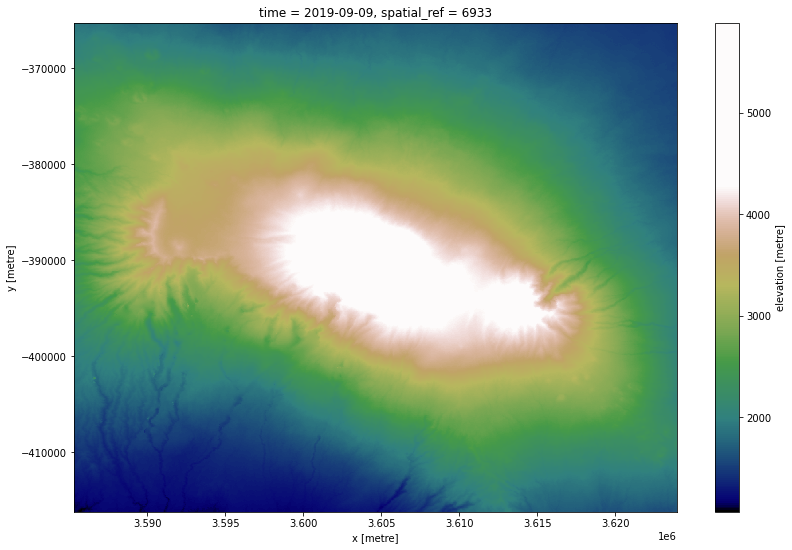

In [6]:
# Create a custom colourmap for the DEM
colors_terrain = plt.cm.gist_earth(np.linspace(0.0, 1.5, 100))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('terrain', colors_terrain)

# Plot a subset of the elevation data
elevation_array.plot(size=9, cmap=cmap_terrain)


## Contour extraction in 'single array, multiple z-values' mode
The `deafrica_spatialtools.subpixel_contours` function uses `skimage.measure.find_contours` to extract contour lines from an array. 
This can be an elevation dataset like the data imported above, or any other two-dimensional or multi-dimensional array. 
We can extract contours from the elevation array imported above by providing a single z-value (e.g. elevation) or a list of z-values. 

### Extracting a single contour
Here, we extract a single 4000 m elevation contour:

In [7]:
# Extract contours
contours_gdf = subpixel_contours(da=elevation_array,
                                 z_values=[4000])

# Print output
contours_gdf


Operating in multiple z-value, single array mode


,z_value,geometry
0,4000,"MULTILINESTRING ((3609135.000 -399258.750, 360..."


This returns a `geopandas.GeoDataFrame` containing a single contour line feature with the z-value (i.e. elevation) given in a shapefile field named `z_value`. 
We can plot the extracted contour over the DEM:

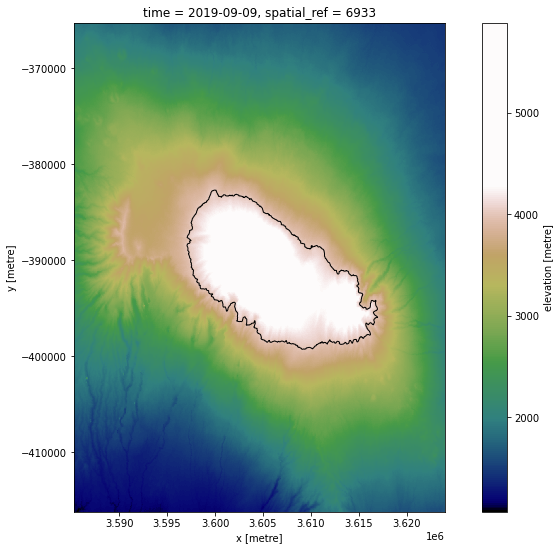

In [8]:
elevation_array.plot(size=9, cmap=cmap_terrain)
contours_gdf.plot(ax=plt.gca(), linewidth=1.0, color='black')  


### Extracting multiple contours 
We can easily import multiple contours from a single array by supplying a list of z-values to extract. 
The function will then extract a contour for each value in `z_values`, skipping any contour elevation that is not found in the array.


Operating in multiple z-value, single array mode


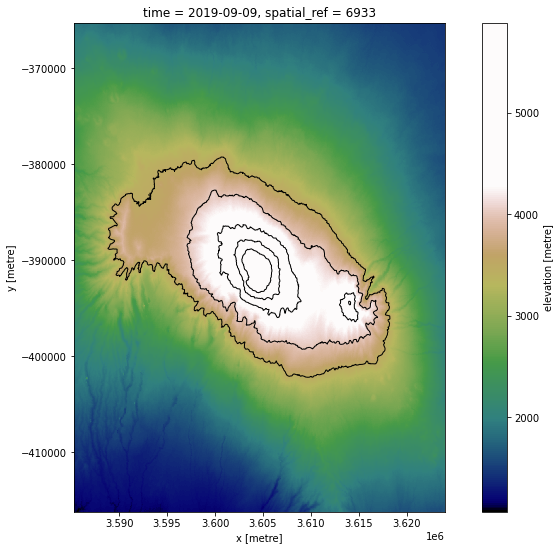

In [9]:
# List of elevations to extract
z_values = [3500, 4000, 4500, 5000, 5500]

# Extract contours
contours_gdf = subpixel_contours(da=elevation_array,
                                 z_values=z_values)

# Plot extracted contours over the DEM
elevation_array.plot(size=9, cmap=cmap_terrain)
contours_gdf.plot(ax=plt.gca(), linewidth=1.0, color='black')


### Custom shapefile attributes
By default, the shapefile includes a single `z_value` attribute field with one feature per input value in `z_values`. 
We can instead pass custom attributes to the output shapefile using the `attribute_df` parameter. 
For example, we might want a custom column called `elev_km` with heights in Kilometres (km) instead of metres (m), and a `location` column giving the location, Mt Kilamanjaro (KLJ). 

We can achieve this by first creating a `pandas.DataFrame` with column names giving the name of the attribute we want included with our contour features, and one row of values for each number in `z_values`:

In [10]:
# Elevation values to extract in metres
z_values = [2000, 3000, 5500]

# Set up attribute dataframe (one row per elevation value above)
attribute_df = pd.DataFrame({'elev_km': [2, 3, 5.5],
                             'location': ['KLJ1', 'KLJ2', 'KLJ3']})

# Print output
attribute_df.head()


,elev_km,location
0,2.0,KLJ1
1,3.0,KLJ2
2,5.5,KLJ3


We can now extract contours, and the resulting contour features will include the attributes we created above:

In [11]:
# Extract contours with custom attribute fields:
contours_gdf = subpixel_contours(da=elevation_array,                               
                                 z_values=z_values,
                                 attribute_df=attribute_df)

# Print output
contours_gdf.head()


Operating in multiple z-value, single array mode


,z_value,elev_km,location,geometry
0,2000,2.0,KLJ1,"MULTILINESTRING ((3585345.000 -367545.000, 358..."
1,3000,3.0,KLJ2,"MULTILINESTRING ((3609975.000 -405387.000, 360..."
2,5500,5.5,KLJ3,"MULTILINESTRING ((3604575.000 -393350.000, 360..."


### Exporting contours to file
To export the resulting contours to file, use the `output_path` parameter. 
The function supports two output file formats:

1. GeoJSON (.geojson)
2. Shapefile (.shp)


In [12]:
subpixel_contours(da=elevation_array,                               
                  z_values=z_values,
                  output_path='output_contours.geojson')


Operating in multiple z-value, single array mode
Writing contours to output_contours.geojson


,z_value,geometry
0,2000,"MULTILINESTRING ((3585345.000 -367545.000, 358..."
1,3000,"MULTILINESTRING ((3609975.000 -405387.000, 360..."
2,5500,"MULTILINESTRING ((3604575.000 -393350.000, 360..."


## Contours from non-elevation datasets in 'single z-value, multiple arrays' mode
As well as extracting multiple contours from a single two-dimensional array, `subpixel_contours` also allows you to extract a single z-value from every array along a specified dimension in a multi-dimensional array. 
This can be useful for comparing the changes in the landscape across time. 
The input multi-dimensional array does not need to be elevation data: contours can be extracted from any type of data. 

For example, we can use the function to extract the boundary between land and water (for a more in-depth analysis using contour extraction to monitor coastal erosion, [see this notebook](../Real_world_examples/Coastal_erosion.ipynb)). 
First, we will load in a time series of Sentinel-2 imagery and calculate a simple Normalized Difference Water Index (NDWI) on two images. 
This index will have high values where a pixel is likely to be open water (e.g. NDWI > 0, coloured in blue below):

In [13]:
# Set up a datacube query to load data for
# first provide a new location (Lake Volta in Ghana)
lat, lon = 6.777, -0.382
buffer = 0.1

#set-up a query
query = {
        'x': (lon-buffer, lon+buffer),
        'y': (lat+buffer, lat-buffer),
         'time': ('2018-01-01', '2018-02-25'),
         'measurements': ['nir_1', 'green'],
         'output_crs': 'EPSG:6933',
         'resolution': (-20, 20)}

# Load Sentinel 2 data
s2_ds = dc.load(product='s2_l2a', 
                group_by='solar_day',
                progress_cbk=with_ui_cbk(),
                **query)
s2_ds


<xarray.Dataset>
Dimensions:      (time: 11, x: 966, y: 1268)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:33:57 ... 2018-02-21T10:30:53
  * y            (y) float64 8.753e+05 8.752e+05 8.752e+05 ... 8.5e+05 8.499e+05
  * x            (x) float64 -4.651e+04 -4.649e+04 ... -2.723e+04 -2.721e+04
    spatial_ref  int32 6933
Data variables:
    nir_1        (time, y, x) uint16 2120 2216 2202 2188 ... 714 720 716 753
    green        (time, y, x) uint16 1062 1090 1082 1068 ... 893 906 904 916
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Calculate NDWI on the first and last image in the dataset

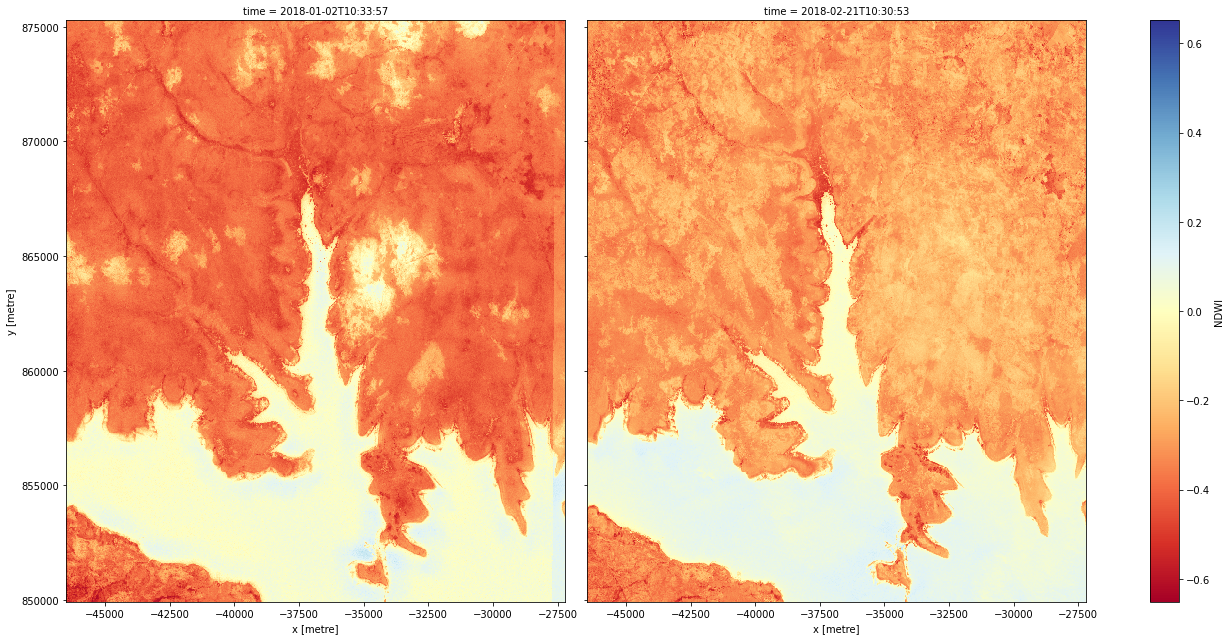

In [14]:
s2_ds = calculate_indices(s2_ds.isel(time=[0, -1]),
                          index='NDWI',
                          collection='s2'
                         )


# Plot the two images side by size
s2_ds.NDWI.plot(col='time', cmap='RdYlBu', size=9)


We can now identify the land-water boundary by extracting the 0 NDWI contour for each array in the dataset along the `time` dimension. 
By plotting the resulting contour lines for a zoomed in area, we can then start to compare phenomenon like lake levels across time.

Operating in single z-value, multiple arrays mode


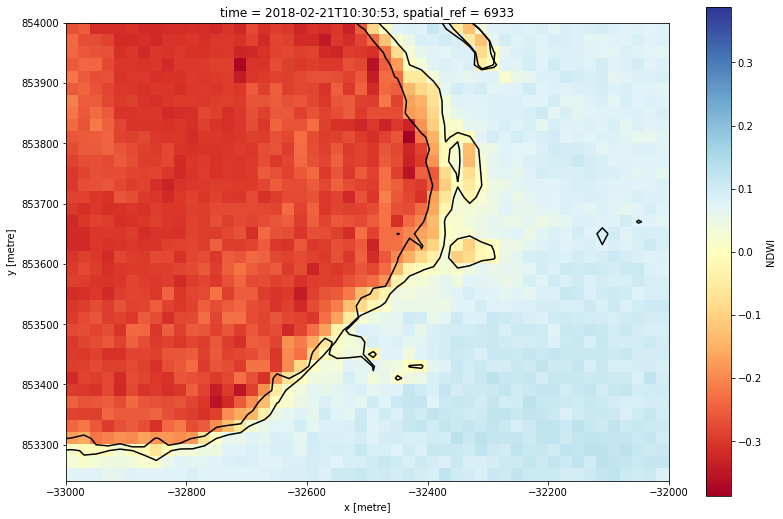

In [15]:
# Extract the 0 NDWI contour from both timesteps in the NDWI data
contours_gdf = subpixel_contours(da=s2_ds.NDWI,
                                 z_values=0,
                                 crs=s2_ds.geobox.crs,
                                 affine=s2_ds.geobox.transform,
                                 dim='time')

# Plot contours over the top of array
s2_ds.NDWI.isel(time=-1).sel(x = slice(-33000, -32000),
                        y = slice(854000, 853250)).plot(size = 9, cmap = 'RdYlBu')

contours_gdf.plot(ax = plt.gca(), linewidth = 1.5, color = 'black')


### Dropping small contours
Contours produced by `subpixel_contours` can include many small features. 
We can optionally choose to extract only contours larger than a certain number of vertices using the `min_vertices` parameter. 
This can be useful for focusing on large contours, and remove possible noise in a dataset. Here we set `min_vertices=10` to keep only contours with at least 10 vertices. 
Observe the small waterbody in the bottom-left of the image disappear:

Operating in single z-value, multiple arrays mode


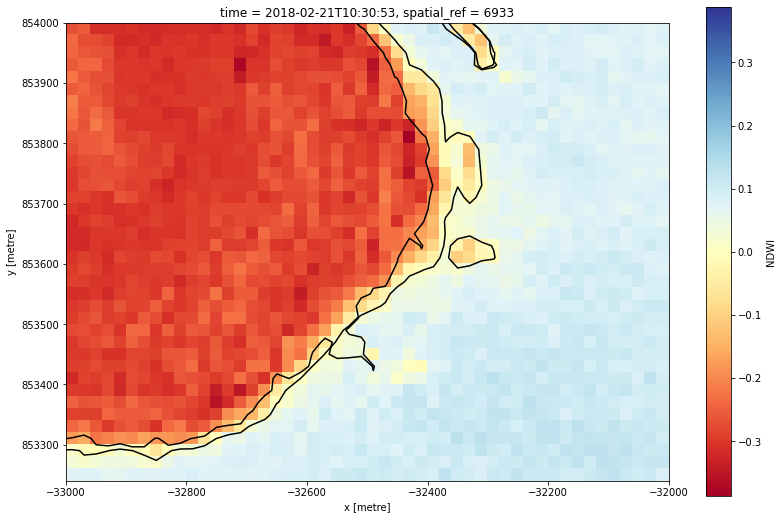

In [16]:
# Extract the 0 NDWI contour from both timesteps in the NDWI data
contours_gdf = subpixel_contours(da=s2_ds.NDWI,
                                 z_values=0,
                                 crs=s2_ds.geobox.crs,
                                 affine=s2_ds.geobox.transform,
                                 min_vertices=10)

# Plot contours over the top of array
# Plot contours over the top of array
s2_ds.NDWI.isel(time=-1).sel(x = slice(-33000, -32000),
                        y = slice(854000, 853250)).plot(size = 9, cmap = 'RdYlBu')

contours_gdf.plot(ax = plt.gca(), linewidth = 1.5, color = 'black')


***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [17]:
print(datacube.__version__)

1.8.0


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)